In [6]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib nbagg

In [7]:
import system_of_units as units

# Definitions and Data

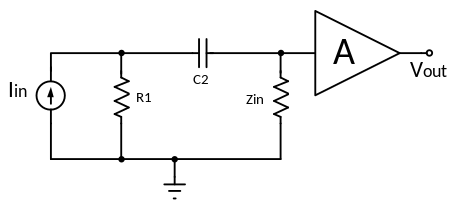

In [207]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_simple.png")

The circuit in figure representss a simple model of the fron-end electronics of the energy plane (FEE). C2 is the  capacitor that decouples the PMT signal from DC. R1 is a large resistor to ground and Z1 is the equivalent impedance of the system. A high pass filter (HPF) originates from 1/(RC), where C = C2 and R:

\begin{equation}
    R = R_1 + Z_{in}
\end{equation}

The amplifier is design to act as a low pass filter (LPF). It is modelled as the convolution of an order 1 LPF and an order 4 LPF.

The front end electronics is modelled by class SimpleFee, and the DAQ by class SimpleDAQ

In [165]:
class SimpleFee:
    """
    Simplified model of Front-end electronics.
    """

    def __init__(self, gain=582.2*units.ohm, C2=8*units.nF, R1=1567*units.ohm, Zin=62*units.ohm, 
                 f_sample=1./(25*units.ns), f_LPF1=3E6*units.hertz, f_LPF2=10E6*units.hertz,
                 noise_rms=0.3*units.mV):
                
        self.R1 = R1
        self.Zin = Zin
        self.C2 = C2
        
        self.MEASURED_GAIN = gain
        r = self.R1*self.Zin/(self.R1+self.Zin)
        A=self.MEASURED_GAIN/r
        self.GAIN = r*A
        
        self.f_sample = f_sample
        self.freq_HPF=1./((self.R1+self.Zin)*self.C2)
        self.freq_LPF1=f_LPF1*2*np.pi
        self.freq_LPF2=f_LPF2*2*np.pi
        self.freq_HPFd=self.freq_HPF /(self.f_sample*np.pi)
        self.freq_LPF1d=self.freq_LPF1 /(self.f_sample*np.pi)
        self.freq_LPF2d=self.freq_LPF2 /(self.f_sample*np.pi)
        
        self.noise_rms = noise_rms
        
    def __str__(self):
        """
        output the class to string
        """
        s = """
        (C2 = {0:7.1f} nf, R1 = {1:7.1f} ohm, Zin = {2:7.1f} ohm, 
         gain = {3:7.1f} ohm, f_sample = {4:7.1f} MH, 
         self.freq_HPF = {5:7.2f} kHz, self.freq_LPF1 = {6:7.2f} MHZ, self.freq_LPF2 = {7:7.2f} MHZ,
         self.freq_HPFd = {8:8.5f}  self.freq_LPF1d = {9:7.2f} self.freq_LPF2d = {10:7.2f},
         noise_rms = {11:7.2f} mV)
        """.format(self.C2/units.nF, self.R1/units.ohm, self.Zin/units.ohm, self.GAIN/units.ohm, 
                   self.f_sample/units.MHZ,
                   self.freq_HPF/(units.kHz*2*np.pi), 
                   self.freq_LPF1/(units.MHZ*2*np.pi), self.freq_LPF2/(units.MHZ*2*np.pi), 
                   self.freq_HPFd, self.freq_LPF1d, self.freq_LPF2d, self.noise_rms/units.mV )
        return s
    def __repr__(self):
        """
        class representation
        """
        return self.__str__()

In [166]:
sfe = SimpleFee()

In [171]:
sfe


        (C2 =     8.0 nf, R1 =  1567.0 ohm, Zin =    62.0 ohm, 
         gain =   582.2 ohm, f_sample =    40.0 MH, 
         self.freq_HPF =   12.21 kHz, self.freq_LPF1 =    3.00 MHZ, self.freq_LPF2 =   10.00 MHZ,
         self.freq_HPFd =  0.00061  self.freq_LPF1d =    0.15 self.freq_LPF2d =    0.50,
         noise_rms =    0.30 mV)
        

In [144]:
class SimpleDAQ:
    """
    Simplified model of DAQ
    """
    
    def __init__(self, nbits=12):
        
        self.NBITS = nbits
        self.LSB = 2*units.volt/2**self.NBITS
        self.voltsToAdc = self.LSB/(units.volt*1.25)
        
    def __str__(self):
        """
        output the class to string
        """
        s = """
        (NIBTS = {0:d}, LSB = {1:7.2g} volts/adc, volts to adc = {2:7.2g})
        """.format(self.NBITS, self.LSB/units.volt, self.voltsToAdc)
        return s
    def __repr__(self):
        """
        class representation
        """
        return self.__str__()
    


In [145]:
sdaq = SimpleDAQ()

In [146]:
sdaq


        (NIBTS = 12, LSB = 0.00049 volts/adc, volts to adc = 0.00039)
        

In [160]:
def spe_i_to_adc(sfee,sdaq):
    """
    input: instances of classes SimpleFEE, SimpleDAQ
    outputs: current to adc counts
    """
    return sfee.GAIN/sdaq.voltsToAdc

In [161]:
def spe_i_to_v(sfee):
    """
    input: instance of class SimpleFee
    output: current to voltage
    """
    return sfee.GAIN

In [169]:
def noise_adc(sfee, sdaq):
    """
    input: instances of classes SimpleFEE, SimpleDAQ
    outputs: adc noise
    """
    return sfee.noise_rms/units.volt/sdaq.voltsToAdc

In [151]:
spe_i_to_adc(sfe,sdaq)*100*units.muA

0.00014904319999999998

In [158]:
spe_i_to_v(sfe)*units.muA/units.mV

0.5821999999999998

In [170]:
noise_adc(sfe, sdaq)

0.768

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

In [172]:
class SPE:

  def __init__(self, sfe, pmt_gain=4.5e6, x_slope = 5*units.ns, x_flat = 1*units.ns):
    """
    Defines a spe 
    """
    self.sfe = sfe
    self.pmt_gain = pmt_gain
    self.x_slope = x_slope
    self.x_flat = x_flat
    
    self.spe_base = self.x_slope + self.x_flat
    self.spe_length = 2*self.x_slope + self.x_flat

    self.A = self.pmt_gain*units.eplus/self.spe_base  #current  
    self.V = self.A*spe_i_to_v(sfe)
    time_step = 1.*units.ns
    self.t = np.arange(0, self.spe_length, time_step)
    nns = int(self.x_slope/time_step)
    nnf = int(self.x_flat/time_step)
    rise = np.linspace(0, self.A, num=nns)
    fall = np.linspace(self.A, 0, num=nns)
    flat = self.A*np.ones(nnf)
    self.spe=np.concatenate((rise,flat,fall))
    
    def __str__(self):
        """
        output the class to string
        """
        s = """
        (PMT gain = {0:d}, slope = {1:7.2g} ns, flat = {2:7.2g} ns)
        """.format(self.pmt_gain, self.self.x_slope/units.ns, self.self.x_flat/units.ns)
        return s
    
    def __repr__(self):
        """
        class representation
        """
        return self.__str__()
    

     

In [180]:
def spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns):
    """
    input: an instance of class SPE
    Returns a SPE pulse at time t0
    with baseline extending in steps of time_step from 0 to tmax determined by DELTA_L
    """
    n = int(t0/time_step)
    nmax = int(tmax/time_step)
    
    DELTA=np.zeros(nmax)   #Dirac delta of size DELTA_L
    DELTA[n]=1
    step = time_step/units.ns
    #spe_pulse_t =np.arange(0, len(DELTA) + len(self.spe) -1, step)
    spe_pulse = signal.convolve(DELTA, spe.spe)
    
    return spe_pulse

  

In [181]:
spe = SPE(sfe)

<IPython.core.display.Javascript object>


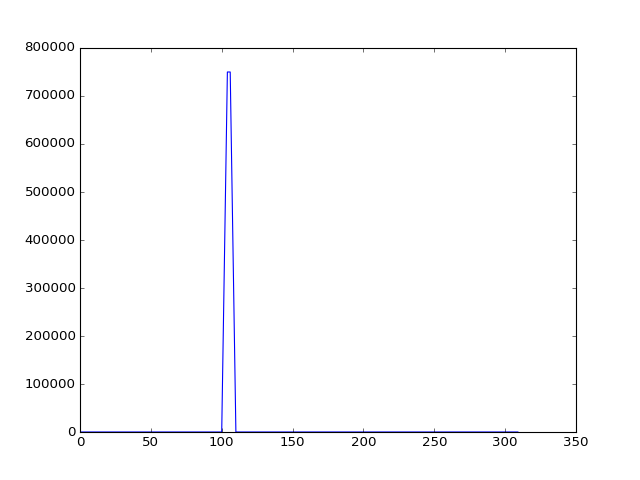

In [182]:
plt.plot(spe_pulse(spe,t0=100*units.ns, tmax=300*units.ns))

In [193]:
def spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, 
                    time_step=1*units.ns):
    """
    Input: an instance of class SPE
    Returns a train of SPE pulses between tlow and tup separated by tstep
    """
    nmin = int(signal_start/time_step)
    nmax = int((signal_start + signal_length)/time_step)
    NMAX = int(daq_window/time_step)
    step = time_step/units.ns

    DELTA=np.zeros(NMAX)
    DELTA[nmin:nmax+1] = 1
    #spe_pulse_t =np.arange(0,len(DELTA) + len(self.spe) -1,step)
    spe_pulse = signal.convolve(DELTA, spe.spe)
      
    return spe_pulse

<IPython.core.display.Javascript object>


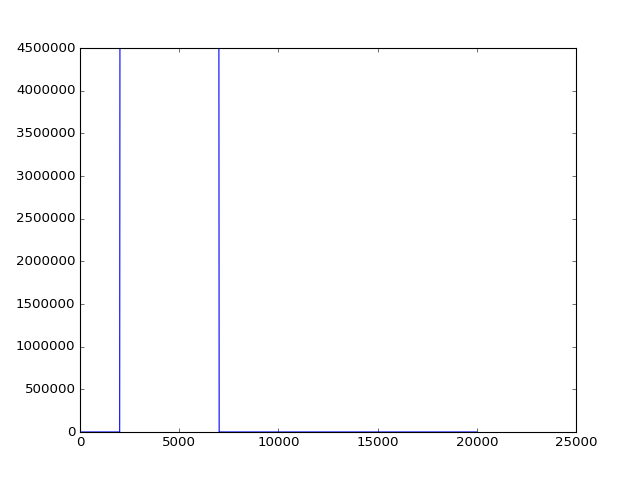

In [194]:
plt.plot(spe_pulse_train(spe))

In [187]:
  def spe_pulse_from_vector(spe,cnt):
    """
    input: an instance of spe
    Returns a train of SPE pulses corresponding to vector cnt
    """
    
    spe_pulse = signal.convolve(cnt[0:-len(self.spe)+1], self.spe)
      
    return spe_pulse

### Modeling FEE as the convolution of HPF and LPF filters

In [235]:
def filter_fee(sfe):
    """
    input: an instance of class SimpleFee
    output: buttersworth parameters of the equivalent FEE filter
    """
    b0, a0 = signal.butter(1, sfe.freq_HPFd, 'high', analog=False) # high pass butterswoth filter ~1/RC
    b1, a1 = signal.butter(1, sfe.freq_LPF1d, 'low', analog=False) # LPF order 1
    b2, a2 = signal.butter(4, sfe.freq_LPF2d, 'low', analog=False) # LPF order 4
    a_aux=np.convolve(a0,a1,mode='full') # convolve HPF, LPF1
    a=np.convolve(a_aux,a2,mode='full') # convolve HPF+LPF1, LPF2
    b_aux=np.convolve(b0,b1,mode='full') 
    b_aux2=np.convolve(b_aux,b2,mode='full') 
    b=sfe.GAIN*b_aux2
    return b,a
    

In [236]:
b,a = filter_fee(sfe)

In [237]:
print(a,b/units.ohm)

(array([ 1.        , -1.61088427,  1.09765517, -0.78293618,  0.31493283,
       -0.02845595,  0.01080426]), array([ 10.58277784,  42.33111137,  52.91388922,   0.        ,
       -52.91388922, -42.33111137, -10.58277784]))


In [238]:
def plot_filter(sfe):
    """
    plots the filter
    """
    b,a = filter_fee(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(freq_HPFd/units.kHz, color='green') # cutoff frequency
    plt.show()

<IPython.core.display.Javascript object>


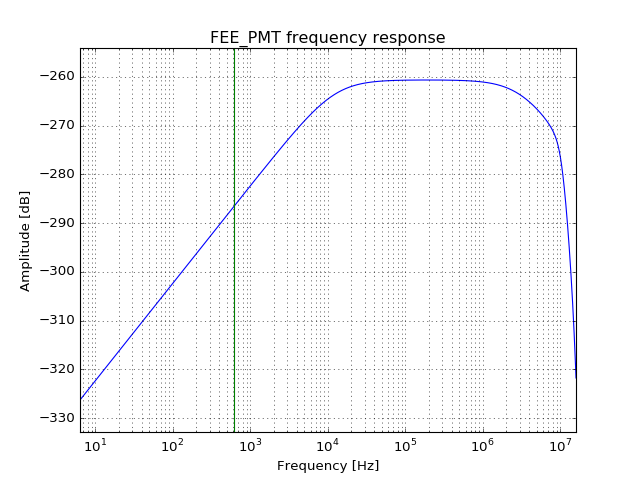

In [239]:
plot_filter(sfe)

In [ ]:
def filter_fee_lpf(sfe):
    """
    input: an instance of class SimpleFee
    output: buttersworth parameters of the equivalent FEE filter
    """
    b0, a0 = signal.butter(1, sfe.freq_HPFd, 'high', analog=False) # high pass butterswoth filter ~1/RC
    b1, a1 = signal.butter(1, sfe.freq_LPF1d, 'low', analog=False) # LPF order 1
    b2, a2 = signal.butter(4, sfe.freq_LPF2d, 'low', analog=False) # LPF order 4
    a_aux=np.convolve(a0,a1,mode='full') # convolve HPF, LPF1
    a=np.convolve(a_aux,a2,mode='full') # convolve HPF+LPF1, LPF2
    b_aux=np.convolve(b0,b1,mode='full') 
    b_aux2=np.convolve(b_aux,b2,mode='full') 
    b=sfe.GAIN*b_aux2
    return b,a
    

### Effect of FEE in a square signal

#### Generate a square signal as a train of SPE

In [243]:
signal_PE = spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus)

<IPython.core.display.Javascript object>


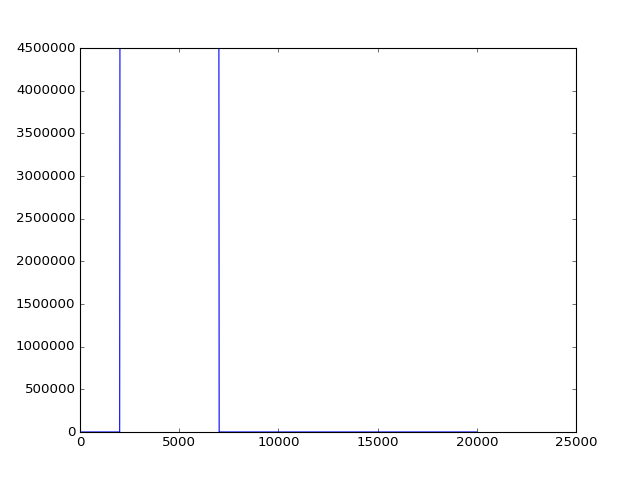

In [244]:
plt.plot(signal_PE)

#### Effect of FEE

In [240]:
def signal_fee(sfe,signal_in):
    """
    input: instance of class sfe and a signal
    outputs: signal convolved with effect FEE
    """
    b, a = filter_fee(sfe)
    return signal.lfilter(b/sfe.GAIN,a,signal_in)

In [245]:
sgn_fee =signal_fee(sfe,signal_PE)

<IPython.core.display.Javascript object>


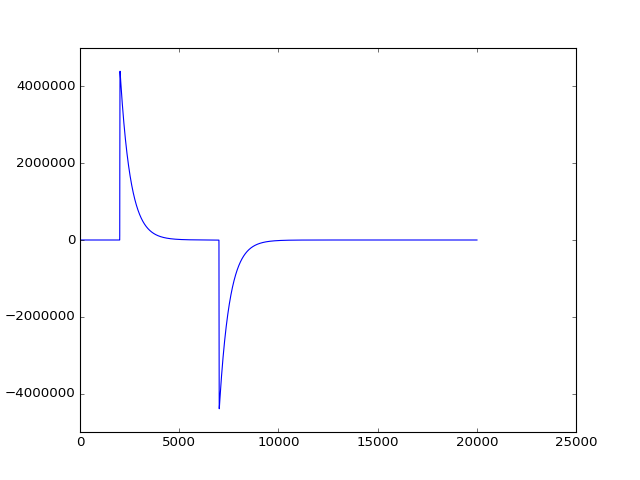

In [246]:
plt.plot(sgn_fee)

### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [213]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [214]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

<IPython.core.display.Javascript object>


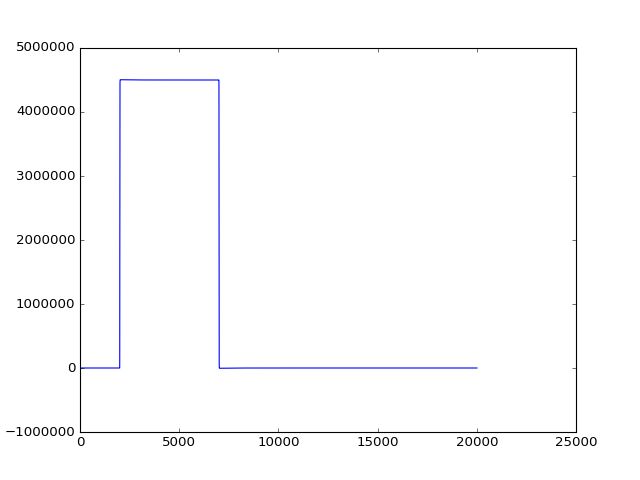

In [215]:
plt.plot(signal_r)

<IPython.core.display.Javascript object>


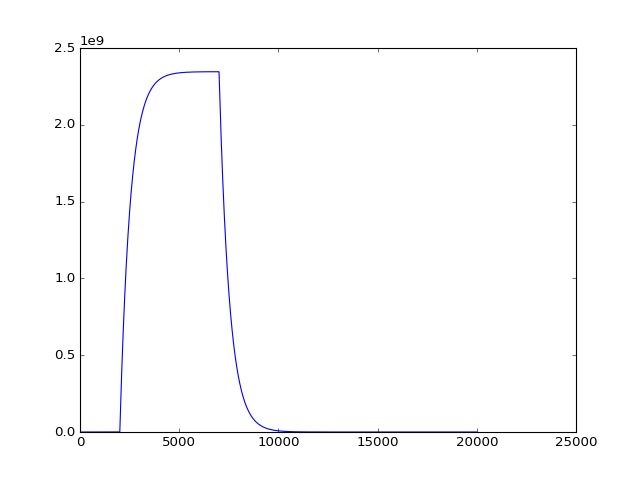

In [216]:
plt.plot(acum)

### Ideal case: perfect deconvolution

<IPython.core.display.Javascript object>


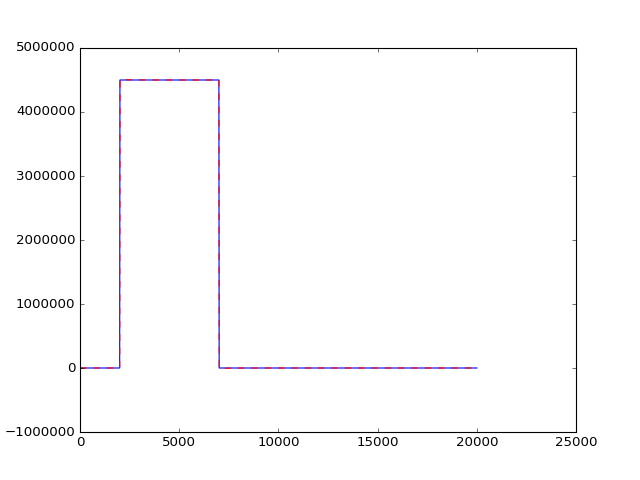

In [225]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'r--', linewidth=1)
plt.show()

### Convolution/Deconv for short signals

In [226]:
signal_PE = spe_pulse(spe,t0=100*units.ns, tmax=500*units.ns)

<IPython.core.display.Javascript object>


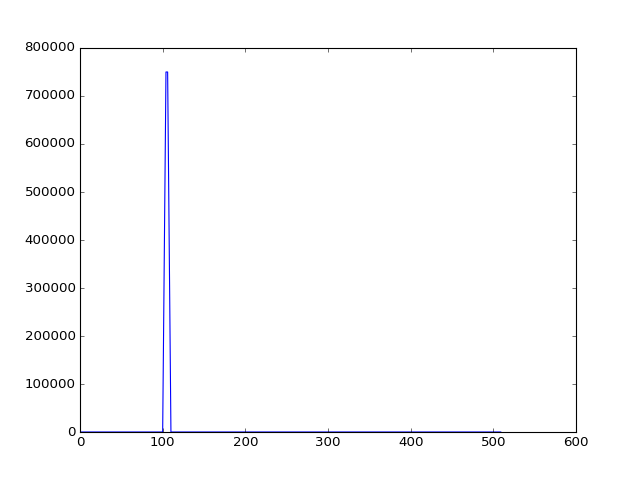

In [227]:
plt.plot(signal_PE)

In [228]:
sgn_fee =signal_fee(sfe,signal_PE)

<IPython.core.display.Javascript object>


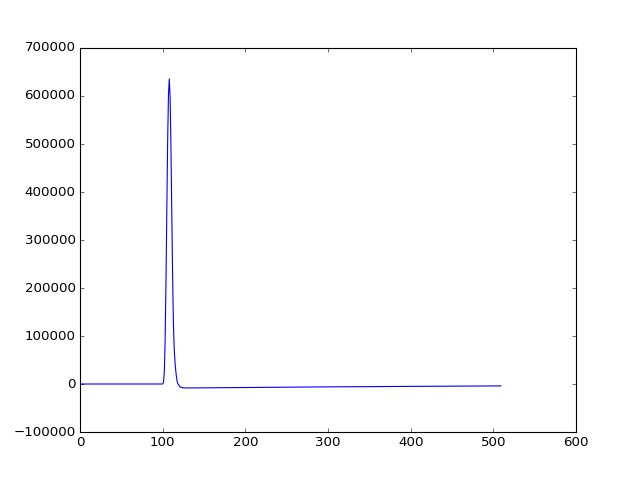

In [229]:
plt.plot(sgn_fee)

In [230]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

<IPython.core.display.Javascript object>


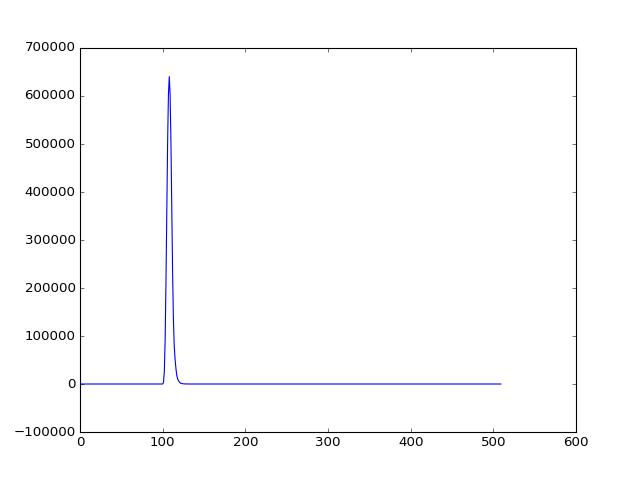

In [231]:
plt.plot(signal_r)

<IPython.core.display.Javascript object>


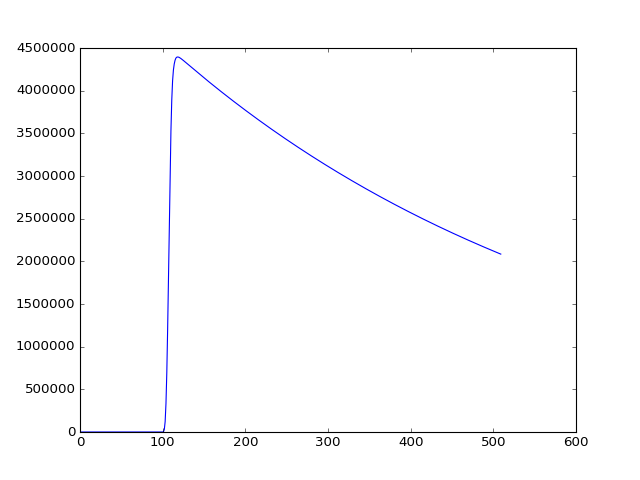

In [232]:
plt.plot(acum)

<IPython.core.display.Javascript object>


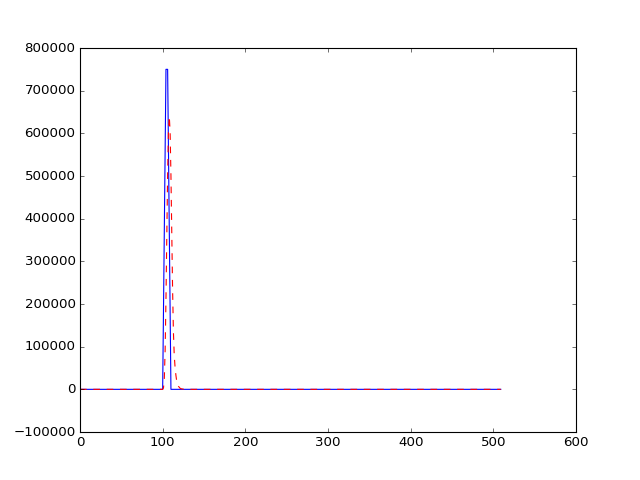

In [233]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'r--', linewidth=1)
plt.show()

#### NB: the deconvolution algorithm deconvolves the HPF, but the effect of the LPF, which is invisible in long signals appears evident in the single photoelectron pulse.

In [234]:
np.sum(signal_r)/np.sum(signal_PE)

1.0004441882210795

In [113]:
def simple_blr(signal_daq, coef, nm,  thr):

    """
    simple blr

    """

    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.float64)
    
    B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = signal.lfilter(B_MAU, 1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]
    
    print('coef = {0:7.5f} baseline = {1:7.2f}'.format(coef,BASELINE))
    
    signal_r[0:nm] = signal_daq[0:nm] 

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window
        
    pulse_on = 0
    offset = 0
    for k in range(nm,len_signal_daq): 
        
        trigger_line = MAU[k-1] + thr
        
        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or pulse_on == 1:
            if pulse_on == 0:
                pulse_on = 1
                # offset computed as the value of MAU before pulse starts
                offset = MAU[k-1] 
                
                print('trigger at k = {}, MAU = {} offset = {}, accum = {}'.format(k, MAU[k-1], offset, acum[k-1]))
                print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))
            if k%100 == 0:
                print('k = {} trigger_line = {} pulse_on = {} MAU = {} signal_d = {} signal_r = {}'.format(k,
                                                                                        trigger_line,
                                                                                        pulse_on,
                                                                                        MAU[k-1],
                                                                                        signal_daq[k],
                                                                                        signal_r[k-1]))



            MAU[k] = MAU[k-1] # MAU is frozen
            
            #update recovered signal, correcting by offset           
            #acum[k] = acum[k-1] + signal_daq[k] - offset;
            #signal_r[k] = signal_daq[k] + coef*acum[k]
            
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset;
            
            
        elif pulse_on == 0: #update MAU
                    
            part_sum = 0.
            for j in range(k-nm, k): 
                part_sum += signal_daq[j]
            part_sum /=nm
            MAU[k] = part_sum
            acum[k] = MAU[k-1]
            signal_r[k] = signal_daq[k]
                
                       
    print('baseline = {} offset = {}'.format(BASELINE, offset))
    return  signal_r - BASELINE, MAU, acum




In [114]:
s_rec, mau, acum = simple_blr(signal_daq=sgn_fee, coef=sfe.freq_HPFd*np.pi, nm=100,  thr=0.1)

coef = 0.00192 baseline =    0.00
baseline = 0.0 offset = 0


<IPython.core.display.Javascript object>


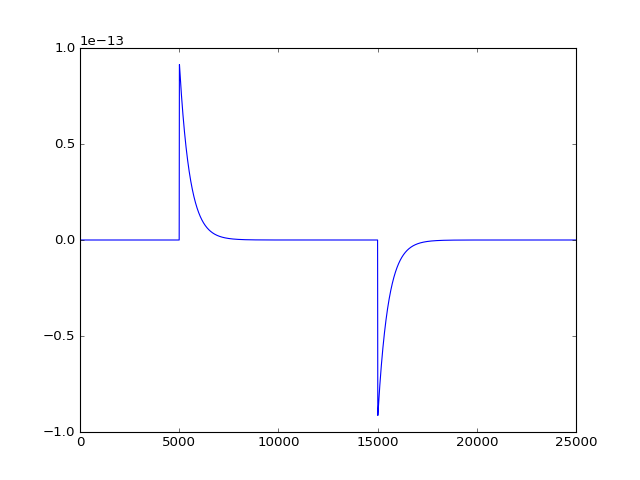

In [112]:
plt.plot(sgn_fee)

In [3]:
f_sample = (1/25E-9); # Hz


R1=1567; 
Zin=62; 
C2=8E-9; 
MEASURED_GAIN = 582.237
A=MEASURED_GAIN/(R1*Zin/(R1+Zin))
GAIN=(R1*Zin/(R1+Zin))*A 
# Seems stupid. It's just to remember true GAIN measured in simulation 

freq_HPF=1/((R1+Zin)*C2); print 'HPF1(kHz) =',freq_HPF/(1E3*2*np.pi)
freq_LPF1=3E6*2*np.pi; print 'LPF1(MHz) =',freq_LPF1/(1E6*2*np.pi)
freq_LPF2=10E6*2*np.pi; print 'LPF2(MHz) =',freq_LPF2/(1E6*2*np.pi)

freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d



HPF1(kHz) = 12.2126260813
LPF1(MHz) = 3.0
LPF2(MHz) = 10.0
HPF(rad/sec) = 76734.1927563 // (half-cycles/sample) = 0.000610631304067
LPF1(rad/sec) = 18849555.9215 // (half-cycles/sample) = 0.15
LPF2(rad/sec) = 62831853.0718 // (half-cycles/sample) = 0.5


In [51]:
b0, a0 = signal.butter(1, freq_HPFd, 'high', analog=False)
b1, a1 = signal.butter(1, freq_LPF1d, 'low', analog=False); b2, a2 = signal.butter(4, freq_LPF2d, 'low', analog=False);
a_aux=np.convolve(a0,a1,mode='full'); a=np.convolve(a_aux,a2,mode='full')
b_aux=np.convolve(b0,b1,mode='full'); b_aux2=np.convolve(b_aux,b2,mode='full'); b=GAIN*b_aux2
print(a,b)

(array([ 1.        , -1.61088427,  1.09765517, -0.78293618,  0.31493283,
       -0.02845595,  0.01080426]), array([ 10.5834504,  42.3338016,  52.917252 ,   0.       , -52.917252 ,
       -42.3338016, -10.5834504]))


<IPython.core.display.Javascript object>


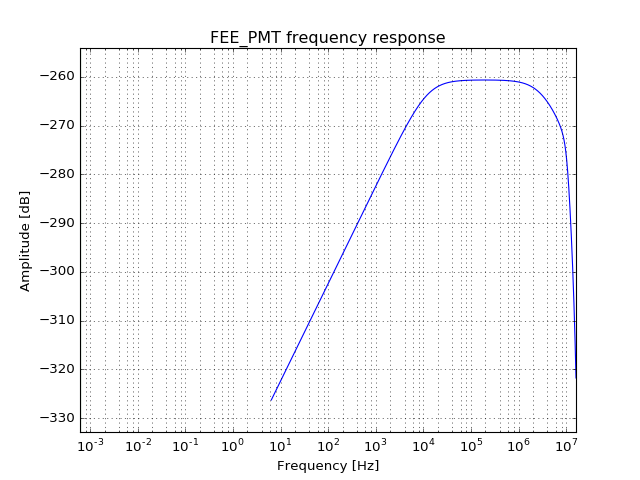

In [40]:
w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
plt.figure(2)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPFd, color='green') # cutoff frequency
plt.show()

In [123]:
signal_in = np.concatenate((np.zeros((1,1000)),np.ones((1,10000)),np.zeros((1,20000))),axis=1)
signal_out = signal.lfilter(b,a,signal_in[0,0:])

<IPython.core.display.Javascript object>


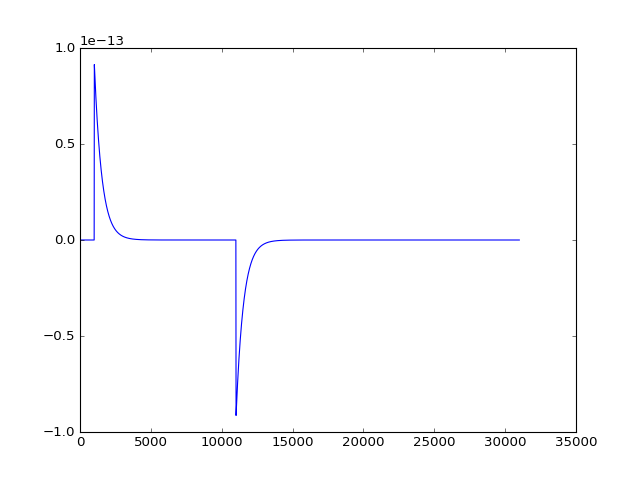

In [129]:
plt.plot(signal_out)

<IPython.core.display.Javascript object>


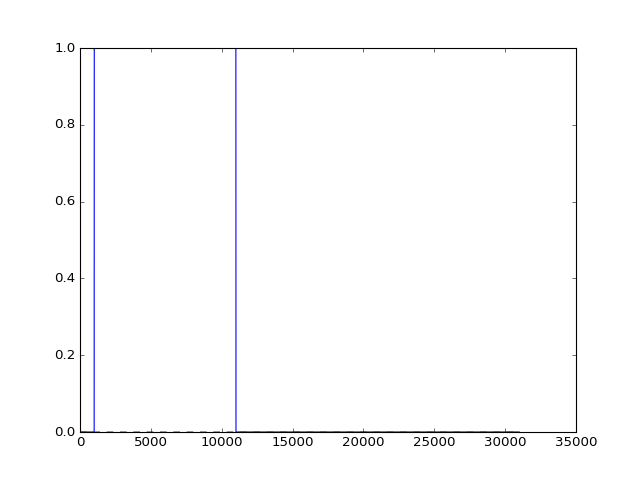

31000


In [127]:
recons = BLRc(signal_daq=signal_out,coef=freq_HPFd*np.pi,thr1 = 0.01)/GAIN
# BLR reconstruction with pure algortihm
plt.figure(1)
plt.plot(range(0,np.size(signal_in),1),signal_in[0,0:])
print np.size(signal_out)
plt.plot(range(0,np.size(recons),1),recons,'r--', linewidth=1)
plt.show()

In [9]:
print 'Input Energy =', np.sum(signal_in)
print 'Reconstructed Energy =', np.sum(recons)
print 'Error in Energy Computation (%) = ', (np.sum(signal_in)-np.sum(recons))/np.sum(signal_in)*100

Input Energy = 10000.0
Reconstructed Energy = 9999.99693326
Error in Energy Computation (%) =  3.06674181411e-05
